In [2]:
# Jupyter Notebook Cell 1

# ========== Imports and Setup ==========

import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# If you haven't downloaded stopwords before, uncomment:
# nltk.download('stopwords')
# nltk.download('punkt')

import scipy
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
# %pip install seaborn
import seaborn as sns

# For nice plots in Jupyter:
%matplotlib inline

# ========== End of Imports ==========


In [3]:
# Jupyter Notebook Cell 2

# ========== 1. Load and Clean the Text File ==========

# Replace 'text8.txt' with the path to your file.
filename = "text8.txt"

# Read file
with open(filename, "r", encoding="utf-8") as f:
    text = f.read()

# Basic cleaning: lowercase, remove punctuation, digits, and non-ASCII chars
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r'[^\x00-\x7F]+', ' ', txt)  # remove non-ASCII
    txt = re.sub(r'\d+', '', txt)            # remove digits
    txt = re.sub(r'[^\w\s]', '', txt)        # remove punctuation
    return txt

text = clean_text(text)

# Tokenize
tokens = word_tokenize(text)

# (Optional) Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [t for t in tokens if t not in stop_words and t.strip() != ""]

print(f"Number of tokens after cleaning and stopword removal: {len(tokens)}")
print("Sample tokens:", tokens[:30])


Number of tokens after cleaning and stopword removal: 10888361
Sample tokens: ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe', 'act', 'used', 'violent', 'means', 'destroy']


In [3]:
# Jupyter Notebook Cell 3

# ========== 2. Build Vocabulary (Optionally Limit Size) ==========

# Count frequency of all tokens
freq = Counter(tokens)

# Sort by frequency (descending)
most_common = freq.most_common()

# Example: choose top 3000 words (adjust as needed to control memory)
vocab_size = 3000
vocab_list = [w for w, _ in most_common[:vocab_size]]

# Create a mapping (word -> index)
vocab = {word: idx for idx, word in enumerate(vocab_list)}

print("Vocab size:", len(vocab))
print("First 20 vocab words:", vocab_list[:20])


Vocab size: 3000
First 20 vocab words: ['one', 'zero', 'nine', 'two', 'eight', 'five', 'three', 'four', 'six', 'seven', 'also', 'first', 'many', 'new', 'used', 'american', 'time', 'see', 'may', 'world']


In [4]:
# Jupyter Notebook Cell 4

# ========== 3. Construct the Co-occurrence Matrix ==========

# We will use a window_size of 2 (left+right), but you can modify.
window_size = 2

# We'll build co_occurrences dict: word -> Counter of neighbors
co_occurrences = defaultdict(Counter)

for i, word in enumerate(tokens):
    # Skip if not in vocab
    if word not in vocab:
        continue
    
    # We consider a window around the word
    start = max(0, i - window_size)
    end   = min(len(tokens), i + window_size + 1)
    for j in range(start, end):
        if j != i:  # don't count the word itself
            neighbor = tokens[j]
            if neighbor in vocab:
                co_occurrences[word][neighbor] += 1

# Initialize cooccurrence matrix (dense)
# This can be large if vocab_size is big!
co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

# Fill the matrix
for w, neighbors in co_occurrences.items():
    w_idx = vocab[w]
    for neigh, count in neighbors.items():
        neigh_idx = vocab[neigh]
        co_matrix[w_idx, neigh_idx] = count

print("Co-occurrence matrix shape:", co_matrix.shape)

# Optional: convert to a DataFrame (for debugging or inspection)
# BUT be wary of memory usage if vocab_size is huge!
# co_matrix_df = pd.DataFrame(co_matrix, index=vocab_list, columns=vocab_list)
# co_matrix_df.head()


Co-occurrence matrix shape: (3000, 3000)


In [5]:
# Jupyter Notebook Cell 5

# ========== 4. Convert to Sparse Format ==========

coo_sparse = csr_matrix(co_matrix)
print("Sparse matrix shape:", coo_sparse.shape)
print("NNZ (non-zero entries):", coo_sparse.nnz)


Sparse matrix shape: (3000, 3000)
NNZ (non-zero entries): 3480652


In [6]:
# Jupyter Notebook Cell 6

# ========== 5. Dimensionality Reduction (Truncated SVD) ==========

# Instead of using the raw co-occurrence matrix directly for clustering,
# we typically project it into a lower-dimensional space using SVD.

n_components = 50  # dimension of the word embeddings
svd = TruncatedSVD(n_components=n_components, random_state=42)
word_embeddings = svd.fit_transform(coo_sparse)

print("Word embeddings shape:", word_embeddings.shape)
print("Explained variance ratio (first few):", svd.explained_variance_ratio_[:5])
print("Total explained variance (50 components):", svd.explained_variance_ratio_.sum())


Word embeddings shape: (3000, 50)
Explained variance ratio (first few): [8.21837267e-01 1.21232110e-01 5.13403024e-02 2.38534440e-03
 3.44180528e-04]
Total explained variance (50 components): 0.9994345133769098


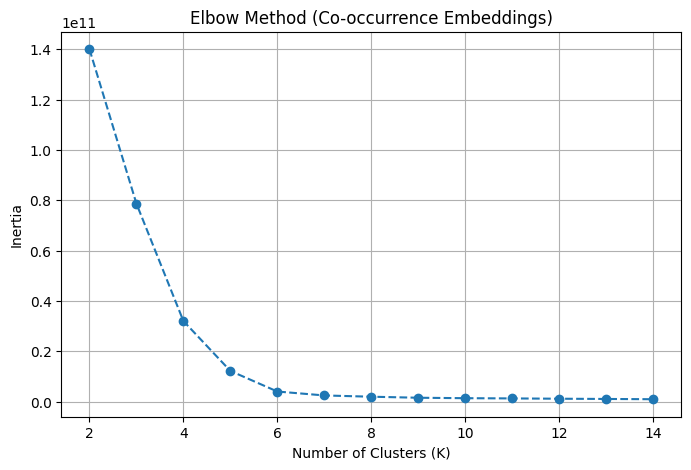

In [8]:
# Jupyter Notebook Cell 7

# ========== 6. K-Means Clustering and Elbow Method ==========

# We'll try a range of cluster numbers (K) and plot the inertia.
k_values = range(2, 15)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(word_embeddings)
    inertias.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.title("Elbow Method (Co-occurrence Embeddings)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


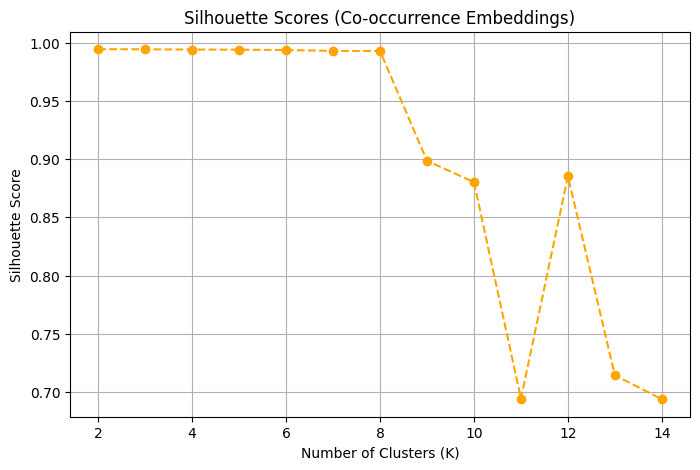

K=2, Silhouette=0.9943
K=3, Silhouette=0.9942
K=4, Silhouette=0.9940
K=5, Silhouette=0.9939
K=6, Silhouette=0.9936
K=7, Silhouette=0.9929
K=8, Silhouette=0.9927
K=9, Silhouette=0.8986
K=10, Silhouette=0.8801
K=11, Silhouette=0.6942
K=12, Silhouette=0.8853
K=13, Silhouette=0.7144
K=14, Silhouette=0.6938


In [9]:
# Jupyter Notebook Cell 8

# ========== 7. Silhouette Scores ==========

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(word_embeddings)
    score = silhouette_score(word_embeddings, labels, metric='euclidean')
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title("Silhouette Scores (Co-occurrence Embeddings)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# You might see a peak or a plateau in the scores.
for k, s in zip(k_values, silhouette_scores):
    print(f"K={k}, Silhouette={s:.4f}")


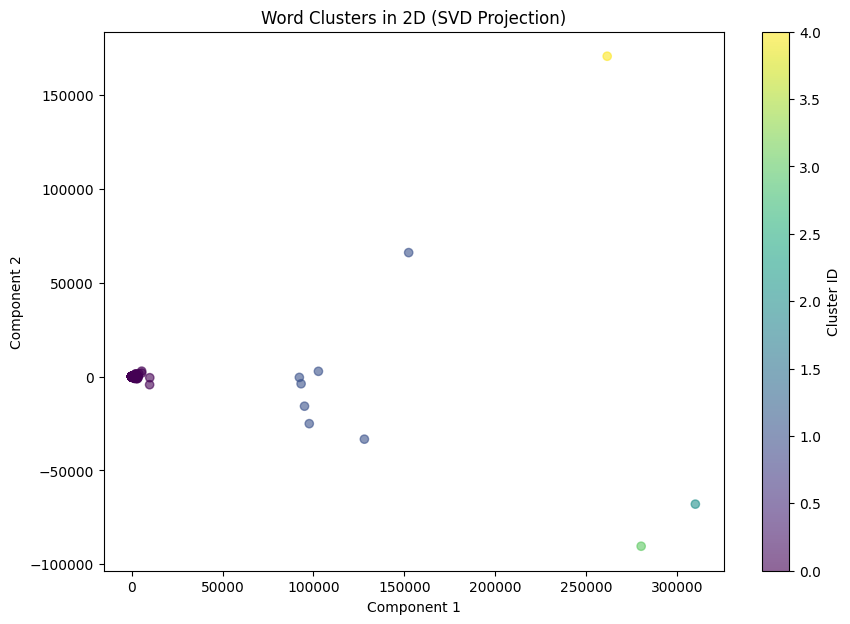

In [10]:
# Jupyter Notebook Cell 9

# ========== 8. Final Clustering and 2D Visualization ==========

# Based on elbow or silhouette, pick a K. Let's pick 5 (example).
final_k = 5
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
final_labels = kmeans.fit_predict(word_embeddings)

# For 2D plotting, let's reduce the embeddings from 50D to 2D.
svd_2d = TruncatedSVD(n_components=2, random_state=42)
word_embeddings_2d = svd_2d.fit_transform(word_embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(word_embeddings_2d[:, 0],
                      word_embeddings_2d[:, 1],
                      c=final_labels,
                      cmap='viridis',
                      alpha=0.6)
plt.title("Word Clusters in 2D (SVD Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


In [11]:
# Jupyter Notebook Cell 10

# ========== 9. Inspecting Word Clusters ==========

# Reverse the 'vocab' dict to map indices -> word
idx_to_word = {idx: w for w, idx in vocab.items()}

# Collect words by cluster
cluster_dict = defaultdict(list)
for i, label in enumerate(final_labels):
    cluster_dict[label].append(idx_to_word[i])

# Print sample words in each cluster
for clust_id, word_list in cluster_dict.items():
    print(f"--- Cluster {clust_id} ---")
    print(word_list[:30], "...\n")  # show first 30 words


--- Cluster 2 ---
['one'] ...

--- Cluster 4 ---
['zero'] ...

--- Cluster 3 ---
['nine'] ...

--- Cluster 1 ---
['two', 'eight', 'five', 'three', 'four', 'six', 'seven'] ...

--- Cluster 0 ---
['also', 'first', 'many', 'new', 'used', 'american', 'time', 'see', 'may', 'world', 'b', 'would', 'however', 'years', 'states', 'people', 'war', 'united', 'known', 'called', 'use', 'th', 'system', 'often', 'state', 'history', 'city', 'english', 'made', 'well'] ...

